# Mount the Device

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Download Packages

In [ ]:
# or clone this repo, removing the '-' to allow python imports:
!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install mxnet
!pip install torchmetrics

Cloning into 'facenet_pytorch'...
remote: Enumerating objects: 1338, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 1338 (delta 233), reused 225 (delta 217), pack-reused 1045 (from 1)
Receiving objects: 100% (1338/1338), 23.19 MiB | 42.10 MiB/s, done.
Resolving deltas: 100% (662/662), done.
Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 4.8 MB/s eta 0:00:00


# Import dependencies

In [ ]:
import numpy as np
np.bool = bool
import mxnet as mx
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
from facenet_pytorch import MTCNN
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torchmetrics import Accuracy
import pickle
import matplotlib.pyplot as plt
import torch_xla.utils.serialization as xser
from Utils import preprocess_image, CANONICAL_LANDMARKS
from CasiaWebFace import CASIAWebFaceDataset
from ArcFace import ArcFaceLoss
from MobileFaceNet import MobileFaceNet
from train_functions import train, train_tpu, validate, test

# Distribute Training

In [5]:
def _mp_fn(rank, flags, rec_file, idx_file):
    # Define the device as TPU
    device = xm.xla_device()

    # Define the mean and std for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Define a named function to replace the lambda
    def preprocess_and_transform(img):
        img = preprocess_image(img)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize(mean=mean, std=std)(img)
        return img

    # Define the transformation pipeline for training with augmentation
    train_transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),  # Rotate by +/- 10 degrees
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),  # Randomly crop and resize to 112x112
      transforms.Lambda(preprocess_and_transform)
    ])

    # Define the transformation pipeline for validation and testing without augmentation
    test_val_transform = transforms.Compose([
        transforms.Lambda(preprocess_and_transform),
    ])

    # Initialize the dataset
    original_dataset = CASIAWebFaceDataset(rec_file, idx_file, transform=None)

    # Get the length of the original dataset
    dataset_length = len(original_dataset)

    # Define the sizes of each split (70-15-15)
    train_size = int(0.7 * dataset_length)
    val_size = int(0.15 * dataset_length)
    test_size = dataset_length - train_size - val_size  # This ensures that the splits sum up to the total size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(original_dataset, [train_size, val_size, test_size])

    # Apply the appropriate transformations to each split
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = test_val_transform
    test_dataset.dataset.transform = test_val_transform

    BATCH_SIZE = 128
    # Create DataLoaders as needed
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)

    # Wrap DataLoader with MpDeviceLoader for TPU distributed loading
    train_loader = pl.MpDeviceLoader(train_loader, device)
    val_loader = pl.MpDeviceLoader(val_loader, device)
    test_loader = pl.MpDeviceLoader(test_loader, device)

    # Initialize model, loss, optimizer, etc.
    model = MobileFaceNet(embedding_size=128).to(device)
    arc_face = ArcFaceLoss(margin=0.3, scale=32, num_classes=original_dataset.get_num_unique_labels(), embedding_size=128, device=device).to(device)

    # Define the optimizer
    optimizer = torch.optim.SGD(
        [
            {'params': model.conv1.parameters()},
            {'params': model.dwconv2.parameters()},
            {'params': model.blocks.parameters()},
            {'params': model.gdconv.parameters()},
            {'params': model.fc.parameters(), 'weight_decay': 0.01},  # Assuming fc is the final fully connected layer with specific weight_decay
            {'params': arc_face.parameters(), 'weight_decay': 0.01 }  # Assuming arc_face refers to the ArcFace layer
        ],
        lr=0.0001,  # Replace with args.lr if using argument passing
        momentum=0.9,  # Replace with args.mom if using argument passing
        weight_decay=0.001,  # Replace with args.weight_decay if using argument passing
        nesterov=True
    )

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    accuracy = Accuracy(task='multiclass', num_classes=original_dataset.get_num_unique_labels()).to(device)

    # Call the training function
    epoch_losses, val_losses, train_accuracies, val_accuracies = train_tpu(
        model, accuracy, device, optimizer, arc_face, scheduler, train_loader, val_loader= val_loader, val_accuracy=accuracy
    )

    # After training, save the metrics to a file
    metrics = {
        "epoch_losses": epoch_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

    metrics_file = f'metrics_rank_{rank}.pkl'
    with open(metrics_file, 'wb') as f:
        pickle.dump(metrics, f)

    xm.rendezvous('save_metrics')  # Synchronize all processes before starting the test evaluation

    #call the test function after rendezvous
    test_epoch_loss, test_epoch_accuracy = test(model, test_loader, arc_face, accuracy, device)

    xm.master_print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.4f}")



# Define any additional flags or arguments
FLAGS = {}

# Define file paths (these should be passed to the function)
rec_file = '/content/drive/MyDrive/casia-webface/train.rec'
idx_file = '/content/drive/MyDrive/casia-webface/train.idx'

# Spawn the training across 8 TPU cores
xmp.spawn(_mp_fn, args=(FLAGS, rec_file, idx_file), nprocs=1, start_method='fork')


Epoch 1/2, Current LR: 0.000100
Train Loss: 20.4976, Train Accuracy: 0.0000
Val Loss: 18.7905, Val Accuracy: 0.0000
Epoch 2/2, Current LR: 0.000100
Train Loss: 18.5894, Train Accuracy: 0.0000
Val Loss: 18.4708, Val Accuracy: 0.0000
Test Loss: 18.4756, Test Accuracy: 0.0000


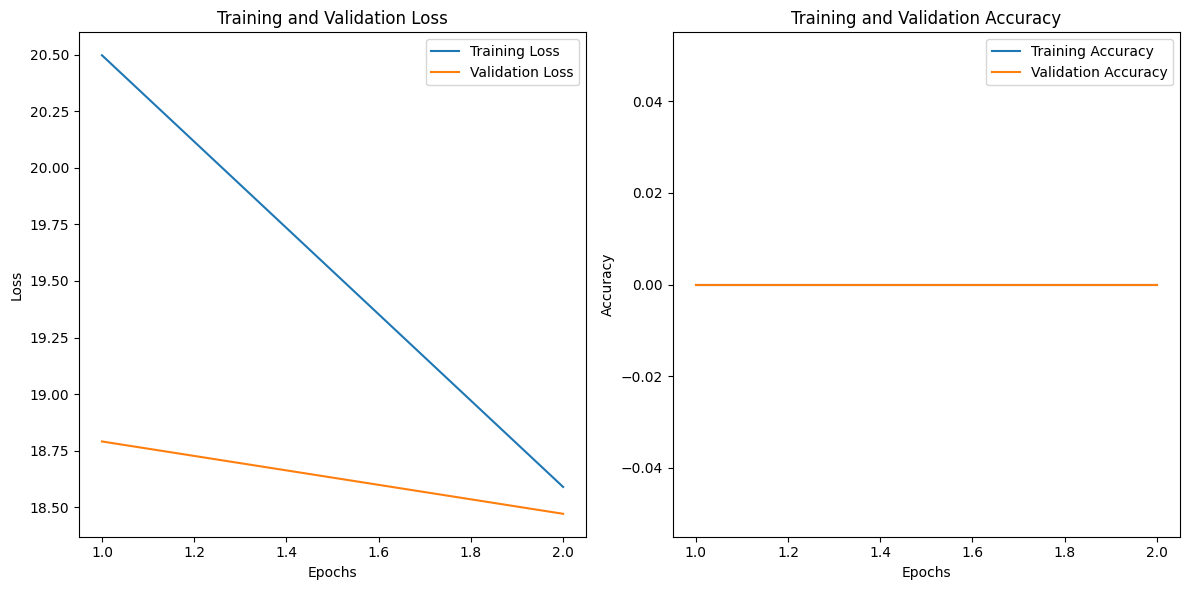

In [6]:
# Load the metrics from the .pkl file
metrics_file = 'metrics_rank_0.pkl'
with open(metrics_file, 'rb') as f:
    metrics = pickle.load(f)

# Extract the metrics
epoch_losses = metrics.get('epoch_losses', [])
val_losses = metrics.get('val_losses', [])
train_accuracies = metrics.get('train_accuracies', [])
val_accuracies = metrics.get('val_accuracies', [])

epochs = range(1, len(epoch_losses) + 1)

plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
